In [3]:
!pip install tensorflow_addons

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%precision %.2f
%tensorflow_version 2.x
import re
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from tensorflow.python.pywrap_tensorflow_internal import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from keras.layers import Embedding

from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout,concatenate
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.models import Model
from keras import regularizers

import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
bglDF = pd.read_csv('/content/drive/MyDrive/UBC-MDS/data586/data/processed_data/BGL_cleaned.csv')

In [25]:
anomaly = [0]*len(bglDF['info'])
normal = [0]*len(bglDF['info'])

for idx, i in enumerate(bglDF['label']):
    if i == 'Anomaly':
      anomaly[idx] = 1
    else:
      normal[idx] = 1

bglDF['anomaly'] = anomaly
bglDF['normal'] = normal

del(anomaly)
del(normal)

In [27]:
#split 20% of train as validation set
X = bglDF['info']
y = bglDF.iloc[:,7:]

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=123)

In [28]:
del(bglDF)

Word Embedding
---
Use a pre-train word2vec model from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

In [29]:
word_vectors = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/UBC-MDS/data586/data/reference_data/GoogleNews-vectors-negative300.bin.gz",binary=True)

In [30]:
# Set Maximum number of words to be embedded
NUM_WORDS = 20000

# Define/Load Tokenize text function
tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'')

# Fit the function on the text
tokenizer.fit_on_texts(X_train)

# Count number of unique tokens
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 1913 unique tokens.


In [31]:
# Convert train and val to sequence
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_validation = tokenizer.texts_to_sequences(X_validation)

In [32]:
# Limit size of train/val to 50 and pad the sequence
X_train = pad_sequences(sequences_train,maxlen=50)
X_validation = pad_sequences(sequences_validation,maxlen=X_train.shape[1])

# Convert target to array
y_train = np.asarray(y_train)
y_validation = np.asarray(y_validation)

# Printing shape
print('Shape of X train and X validation tensor:', X_train.shape,X_validation.shape)
print('Shape of label train and validation tensor:', y_train.shape,y_validation.shape)


Shape of X train and X validation tensor: (379836, 50) (94960, 50)
Shape of label train and validation tensor: (379836, 2) (94960, 2)


In [33]:
EMBEDDING_DIM=300
vocabulary_size=min(len(word_index)+1,(NUM_WORDS))

embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))


for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        vec = np.zeros(EMBEDDING_DIM)
        embedding_matrix[i]=vec

In [34]:
del(word_vectors)

In [35]:
# Dfine Embedding function using the embedding_matrix
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)

In [36]:
del(embedding_matrix)

In [37]:
sequence_length = X_train.shape[1]
filter_sizes = [2,3]
num_filters = 10 #100
drop = 0.4

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)
reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

conv_0 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_1 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)

maxpool_0 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)
maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)

merged_tensor = concatenate([maxpool_0, maxpool_1], axis=1)
#merged_tensor = concatenate([maxpool_0], axis=1)
flatten = Flatten()(merged_tensor)
reshape = Reshape((2*num_filters,))(flatten)
dropout = Dropout(drop)(flatten)
conc = Dense(20)(dropout) #40
output = Dense(units=2, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01))(conc)

# this creates a model that includes
model = Model(inputs, output)

In [40]:
model.compile(optimizer=Adam(1e-2), 
              metrics=['accuracy', 'Precision', 'Recall',tfa.metrics.F1Score(num_classes=2,average='macro')], 
              loss = 'binary_crossentropy')
callbacks = [EarlyStopping(monitor='val_accuracy')]
hist_adam = model.fit(X_train, 
                    y_train, 
                    epochs=5, 
                    validation_data=(X_validation, y_validation), 
                    batch_size=400)
                    #callbacks=callbacks)

Epoch 1/5
950/950 [==============================] - 333s 344ms/step - loss: 0.0214 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - f1_score: 0.9981 - val_loss: 0.0069 - val_accuracy: 0.9999 - val_precision: 0.9999 - val_recall: 0.9999 - val_f1_score: 0.9998
Epoch 2/5
950/950 [==============================] - 320s 337ms/step - loss: 0.0127 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - f1_score: 0.9981 - val_loss: 0.0030 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_f1_score: 0.9998
Epoch 3/5
950/950 [==============================] - 346s 364ms/step - loss: 0.0201 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - f1_score: 0.9975 - val_loss: 0.0032 - val_accuracy: 0.9999 - val_precision: 0.9999 - val_recall: 0.9999 - val_f1_score: 0.9996
Epoch 4/5
950/950 [==============================] - 319s 336ms/step - loss: 0.0128 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - f1_score: 0.9962 - val_loss: 0.0266 - val_accuracy:

In [41]:
test_loss, test_acc, test_precision, test_recall, test_f1 = model.evaluate(X_validation, y_validation, verbose=2 )

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Test Precision:', test_precision)
print('Test Recall:', test_recall)
print('Test F1-Score:', test_f1)

2968/2968 - 16s - loss: 0.0037 - accuracy: 0.9999 - precision: 0.9999 - recall: 0.9999 - f1_score: 0.9998 - 16s/epoch - 5ms/step
Test Loss: 0.003696259343996644
Test Accuracy: 0.9999473690986633
Test Precision: 0.9999473690986633
Test Recall: 0.9999473690986633
Test F1-Score: 0.9998059272766113


(0.00, 0.03)

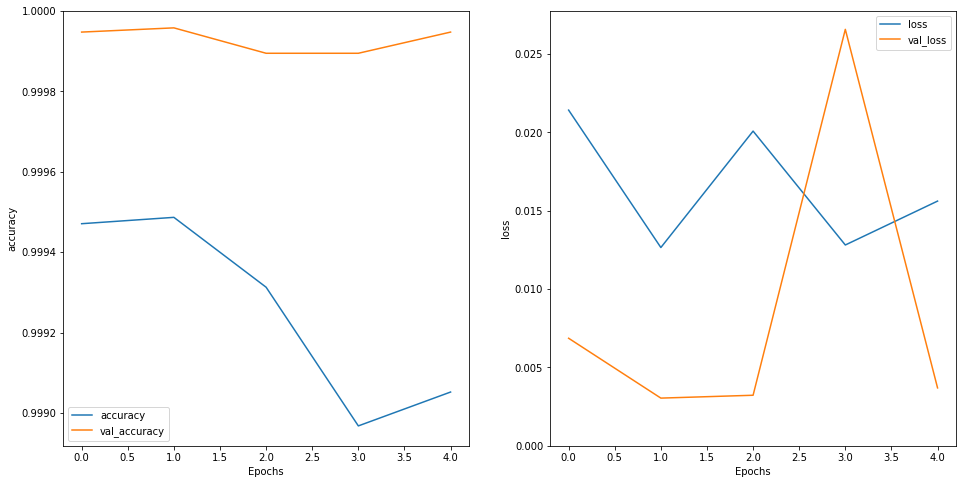

In [42]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(hist_adam, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(hist_adam, 'loss')
plt.ylim(0, None)